In [2]:
import accelerate
import datasets
import evaluate
import numpy as np
import peft
import pickle
import pytest, ipytest
ipytest.autoconfig()
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)


from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
AutoModelForCausalLM,
AutoTokenizer,
BitsAndBytesConfig,
TrainingArguments,
Trainer)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [6]:
print(ds_gst1_test[0])

{'record': 'JAHFAU010000168.1', 'text': 'CTCCTCGGCCAGCAAGCGCATCGTGAGAACCGGACTGACGATCAGCAAAACGGTCGCCAGCGGGCCCAATACCATGCGGCCATCCGGGTTCATCTGGCCGGTCGGCAGGCCAAAGTTAACGTTTAGGGAGAAGATCAGGCCGAGCACCAGGAAGCTGAGGGCGGCGGCCGCGTAAGCCAGCGGCGACACGAAGTAGCGGCGGAACTCGCGCACTGCAATAACCCAGCTGGTGCGCACGATCTAGCTCTCCTGCGGCACGACTTGCTCTTCCTCGCGAGTCAGCAGCAGGAAGATGCTTTCCAGGCTGACCCCGGCCGTTGTCAGCTCCAGCAAGTCCAGATCGGCTTCAACGATGCGGCGCGCCAACAGCGGGCGCAGGTCGCGGCCGGGCGAAGAGATCACCTCCACGGTGCCTGCCTGCCCGGCAAGCTCGACCGACTCCACTCCCGGGACGGACTTGAGCAGGTCGACCAGATCGGCTGCCGGGGCAGAGCTGCGGATCAGAATCCGGTACGCACCGGCCAGCTGGGCCGAAAGATTGGCGGGCGTATCTTCCGCCACCAACCGCCCCTTGTTGATAATCAGGACTCGATCACAAACTTGCTGTGCTTCCGAGAGGATGTGGGTGGACAACATGACGGTCCGCTCCCGCCCGAGCTCTCGGATTAAGTCCCGGACTTCGATGATTTGGGCCGGATCCAGTCCAATGGTCGGCTCGTCCAGGATCAAGACCTCGGGCCGGTGCAAGAGTGCCTGGGCCAGGCCGACCCGCTGTCGCAGACCTTTCGACAGGTTGCCAATCAGGCTATCACCGCGTTTTTCGAGGCCGACCTGCGTTAGGGATTCCTCGACCCGGCCATCCAGGTCCTCCACCCGCCGAAGCGAACCCATGAACGAGAGGTATTCGCGGCCGGACATCTCCGGGTACAGCGGGACGGTCTCCGGCAGGTATCCGACCC

In [7]:
def model_from_pkl(model):
    with open("pkl_files/" + model + ".pkl", "rb") as f:
        pkl_model=pickle.load(f)
    model_name=pkl_model["model_name"]
    tokenizer=pkl_model["tokenizer"]
    tokenizer.pad_token=tokenizer.eos_token
    return model_name, tokenizer

In [8]:
%%ipytest -k imp
#test to check models are properly improted from pkl files
def test_model_imp():
    lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")
    assert type(lla_321)==transformers.models.llama.modeling_llama.LlamaForCausalLM and type(lla_321_tokenizer)==transformers.tokenization_utils_fast.PreTrainedTokenizerFast
          

.                                                                                            [100%]
1 passed in 4.11s


In [9]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")

In [10]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [11]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [12]:
# perform preprocessing on the genomic data
def map_data(data, model, tokenizer):
    def tokenize_l_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)
    def tokenize_m_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=8192)
        
    if type(model)==transformers.models.llama.modeling_llama.LlamaForCausalLM:
        tokenized_dataset=data.map(tokenize_l_function, batched=True)
    else:
        tokenized_dataset=data.map(tokenize_m_function, batched=True)
    return tokenized_dataset

In [13]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [14]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [15]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [16]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

In [17]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [18]:
# before loading in the base model with LoRA, might be good to define a helper function
# this looks at the total parameters a model has, and how many are trainable
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [66]:
training_args=TrainingArguments(output_dir="test_trainer", 
                                #eval_strategy="epoch", 
                                per_device_train_batch_size=8,
                                num_train_epochs=3, # total number of training epochs to perform)
                                learning_rate=2e-4,
                                weight_decay=0.1,
                                logging_strategy="steps",
                                #logging_steps=2,
                                gradient_checkpointing=True)
# eval_strategy=epoch ensures that the evaluation metric will be reported at the end of each epoch
# this helps us monitor evaluation metrics during fine-tuning

# an epoch is one full cycle through a training dataset
# during the epoch, the model sees and learns from all the training examples
# steps are one optimization update
# during a step, parameters are updated based on a batch of training data
#the number of steps per epoch is the total number of training samples divided by batch size
# here we have 3 epochs, 48 steps, 16 steps per epoch
# epochs are best used when you want the model to see the dataset several times, 
 #steps are best used for larger datasets to ensure updates

In [21]:
# A trainer needs to be passed a function from the Evaluate library (specifically the accuracy function) to compute and report metrics
metric=evaluate.load("accuracy")

In [84]:
# the compute_metrics method will calculate prediction accuracy
comp_metrics_output=[]
def compute_metrics(eval_pred):
    logits=eval_pred.predictions
    predictions = np.argmax(logits, axis=-1)
    comp_metrics_output.append(metric.compute(predictions=predictions))
    return metric.compute(predictions=predictions)
    
    # this lets us convert logits (returned by models) into predictions
    # np.argmax returns the indices of the maximum values along the axis of an array
    # axis=-1 means it looks at the last axis in the array
    # metric.compute gathers all cached predictions and references to compute the metric scor

In [23]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [61]:
# the trainer object specifies the model, training arguments, training and test datasets, and evaluation function
def make_trainer(m_model, train_data, test_data, args):
    trainer=SFTTrainer(
        model=m_model,
        train_dataset=train_data,
        eval_dataset=test_data,
        peft_config=config,
        args=args,
        compute_metrics=compute_metrics,
    )
    return trainer
    
# SFTTrainer is best used for training with a pre-trained model and a smaller dataset
# It can be better suited for fine-tuning than regular Trainer


In [68]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [69]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", logging_strategy="steps",
                   logging_steps=2))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

In [45]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, training_args)

In [70]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
2,0.653300
4,0.651800
6,0.643600
8,0.634500
10,0.647000
12,0.643900
14,0.637600
16,0.623600
18,0.622600
20,0.624700


TrainOutput(global_step=48, training_loss=0.629049522181352, metrics={'train_runtime': 973.548, 'train_samples_per_second': 1.541, 'train_steps_per_second': 0.049, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.629049522181352})

In [71]:
m2_trainer.train() #this has a batch size of 8

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=80, training_loss=0.6195927619934082, metrics={'train_runtime': 1505.7487, 'train_samples_per_second': 1.66, 'train_steps_per_second': 0.053, 'total_flos': 1.0927208398848e+17, 'train_loss': 0.6195927619934082})

In [72]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'mistralai/Mistral-7B-Instruct-v0.1' to 'meta-llama/Llama-3.2-1B'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


In [88]:
l_trainer = SFTTrainer(
    model=lla_lora_model,
    train_dataset=l_tokenized_stage1_train,
    eval_dataset=l_tokenized_stage1_test,
    peft_config=config,
    args=SFTConfig(output_dir="test_trainer", 
                   #eval_strategy="steps",
                   logging_strategy="steps",
                   logging_steps=2, 
                  ),
    #compute_metrics=compute_metrics
)

In [58]:
l2_trainer = SFTTrainer(
    model=lla_lora_model,
    train_dataset=l_tokenized_stage1_train,
    eval_dataset=l_tokenized_stage1_test,
    peft_config=config,
    args=training_args,
    compute_metrics=compute_metrics
)

In [89]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
2,0.639400
4,0.648400
6,0.644600
8,0.638900
10,0.651000
12,0.650700
14,0.647500
16,0.640600
18,0.638700
20,0.646700


TrainOutput(global_step=48, training_loss=0.6447452753782272, metrics={'train_runtime': 110.1397, 'train_samples_per_second': 13.619, 'train_steps_per_second': 0.436, 'total_flos': 8976366305280000.0, 'train_loss': 0.6447452753782272})

In [284]:
comp_metrics_output

[]

In [274]:
import pandas as pd

<Axes: >

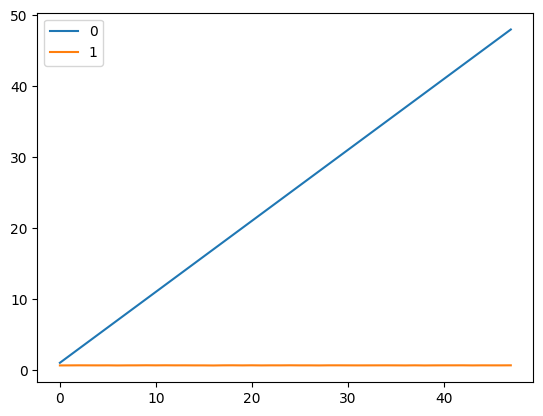

In [280]:
df_data=[[float(val) for val in line.split("\t")] for line in """
1 	0.627300
2 	0.634200
3 	0.642600
4 	0.638500
5 	0.634800
6 	0.638800
7 	0.625000
8 	0.636100
9 	0.638100
10 	0.648400
11 	0.638600
12 	0.646700
13 	0.638600
14 	0.640600
15 	0.633600
16 	0.632200
17 	0.620800
18 	0.640700
19 	0.645200
20 	0.633100
21 	0.644600
22 	0.630600
23 	0.639300
24 	0.637400
25 	0.646500
26 	0.636400
27 	0.636900
28 	0.627700
29 	0.641600
30 	0.641900
31 	0.637200
32 	0.632900
33 	0.635300
34 	0.638200
35 	0.641000
36 	0.636400
37 	0.629400
38 	0.641100
39 	0.626500
40 	0.635800
41 	0.640500
42 	0.640500
43 	0.643200
44 	0.630600
45 	0.640100
46 	0.636500
47 	0.637000
48 	0.643500
""".split("\n")[1:-1]]
df=pd.DataFrame(df_data)

df.plot()

In [78]:
l2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=80, training_loss=0.646525526046753, metrics={'train_runtime': 182.6294, 'train_samples_per_second': 13.689, 'train_steps_per_second': 0.438, 'total_flos': 1.49606105088e+16, 'train_loss': 0.646525526046753})

In [226]:
# try a different version of llama3, see how this impacts performance
l2_tokenized_stage1_train=map_data(ds_gst1_train, lla_323, lla_323_tokenizer)
l2_tokenized_stage1_test=map_data(ds_gst1_test, lla_323, lla_323_tokenizer)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.35 examples/s]


In [231]:
ll2_lora_model=get_peft_model(lla_323, config)
print_trainable_parameters(ll2_lora_model)

trainable params: 2293760 || all params: 3215043584 || trainable%: 0.07


In [234]:
l23_trainer = SFTTrainer(
    model=ll2_lora_model,
    train_dataset=l2_tokenized_stage1_train,
    eval_dataset=l2_tokenized_stage1_test,
    peft_config=config,
    args=training_args,
    compute_metrics=compute_metrics
)
l23_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=48, training_loss=0.6386211315790812, metrics={'train_runtime': 364.8795, 'train_samples_per_second': 4.111, 'train_steps_per_second': 0.132, 'total_flos': 2.5998715256832e+16, 'train_loss': 0.6386211315790812})